General import statements. REMEMBER, DEEPLIFT_DIR needs to point to the deeplift directory WITHIN the deeplift repo

In [14]:
%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to the enhancer_prediction_code repo");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT");
from deepLIFTutils import makePngOfSequenceDeepLIFTScores

import deeplift
import deeplift.conversion.keras_conversion as kc

Load the keras model

In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
model_weights = "modelsDir_runs/record_0_model_uSmpK_modelWeights.h5"
model_yaml = "modelsDir_runs/record_0_model_uSmpK_modelYaml.yaml"
reload(kc)
keras_model = kc.load_keras_model(model_weights, model_yaml, normalise_conv_for_one_hot_encoded_input=True)

Using Theano backend.


Load the data

In [3]:
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to the deeplift code");
sys.path.insert(0,scriptsDir);
from importDataPackage import importData
reload(importData)
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml","yaml/labels.yaml", "yaml/splits.yaml")

(0, 'rows skipped from', 'DensityEmbedding_prefix-gataAndTal_motifs-GATA_disc1+TAL1_known1_min-1_max-6_mean-3_zeroProb-0_seqLength-250_numSeqs-2000.simdata.gz')
(0, 'rows skipped from', 'DensityEmbedding_prefix-gataOnly_motifs-GATA_disc1_min-1_max-6_mean-3_zeroProb-0_seqLength-250_numSeqs-2000.simdata.gz')
(0, 'rows skipped from', 'DensityEmbedding_prefix-talOnly_motifs-TAL1_known1_min-1_max-6_mean-3_zeroProb-0_seqLength-250_numSeqs-2000.simdata.gz')
(0, 'rows skipped from', 'AllNs.gz')
Returning desired dict
Making numpy arrays out of the loaded files
('train', 'shapeX', (6400, 1, 4, 250))
('train', 'shapeY', (6400, 3))
('valid', 'shapeX', (800, 1, 4, 250))
('valid', 'shapeY', (800, 3))
('test', 'shapeX', (800, 1, 4, 250))
('test', 'shapeY', (800, 3))


In [4]:
data = trainData

Convert the keras sequential model into a deeplift sequential model, and compile the functions to compute the contributions and multipliers - the multipliers are analogous to the gradients

In [5]:
from deeplift.blobs import MxtsMode
reload(kc)

<module 'deeplift.conversion.keras_conversion' from '/Users/avantishrikumar/Research/deeplift/deeplift/conversion/keras_conversion.pyc'>

In [6]:
deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT)
deeplift_contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=0)
deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(find_scores_layer_idx=0)

In [7]:
deeplift_expo_upweight_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT, expo_upweight_factor=1)
deeplift_expo_upweight_contribs_func = deeplift_expo_upweight_model.get_target_contribs_func(find_scores_layer_idx=0)

Do the same for other saliency map functions

In [8]:
gradients_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.Gradient)
grad_times_inp_func = gradients_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackprop)
guided_backprop_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0)
deconv_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeconvNet)
deconv_func = deconv_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_deeplift1_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT1)
guided_backprop_deeplift1_func = guided_backprop_deeplift1_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_deeplift4_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT4)
guided_backprop_deeplift4_func = guided_backprop_deeplift4_model.get_target_contribs_func(find_scores_layer_idx=0)

In [9]:
import theano
predictions_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
                                   deeplift_model.get_layers()[-1].get_activation_vars(),
                                   allow_input_downcast=True)

In [10]:
rand_seq = np.zeros(testData.X[0].shape)
rand_seq[0,np.argmax(np.random.random(testData.X[0].shape),axis=1),range(testData.X[0].shape[-1])] = 1
predictions_func([np.zeros(testData.X[0].shape), np.random.random(testData.X[0].shape), rand_seq])

array([[  4.81722683e-01,   3.80871096e-03,   8.13119016e-07],
       [  5.19533575e-01,   1.52097840e-04,   3.81893939e-09],
       [  5.93887316e-03,   9.19927359e-01,   1.61986705e-03]], dtype=float32)

In [11]:
predictions = predictions_func(data.X)

In [12]:
filter_contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=3)

task_idx 0
Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
(6400, 10, 1, 4)


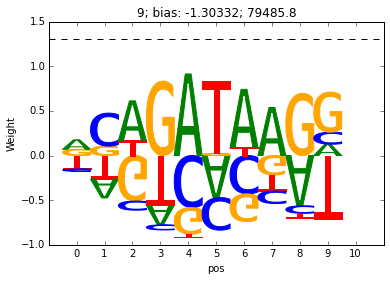

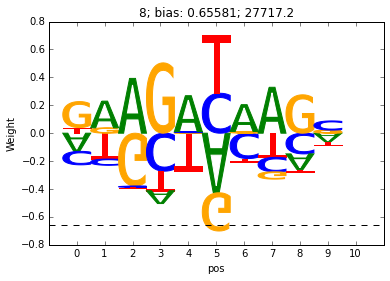

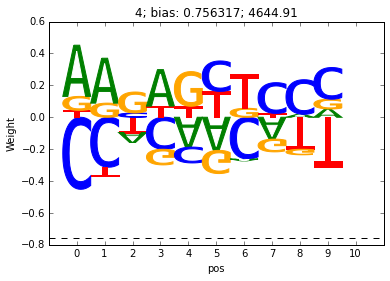

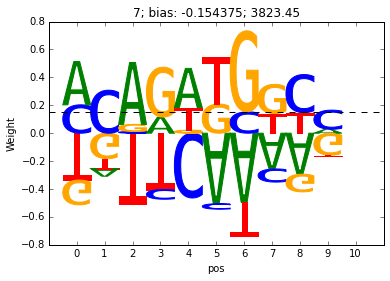

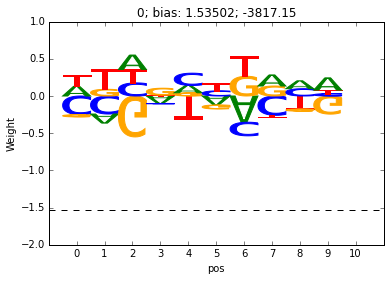

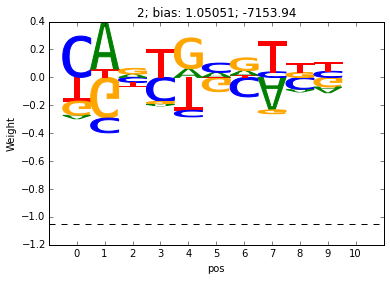

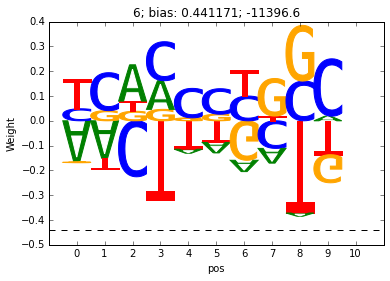

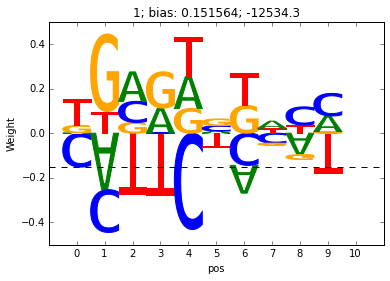

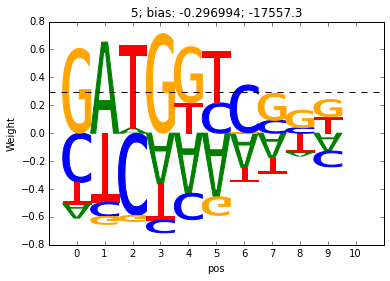

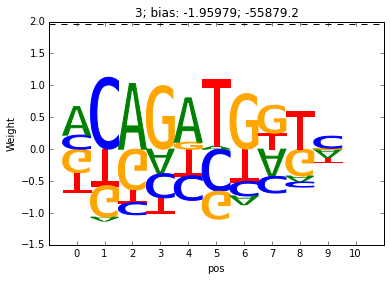

task_idx 1
Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
(6400, 10, 1, 4)


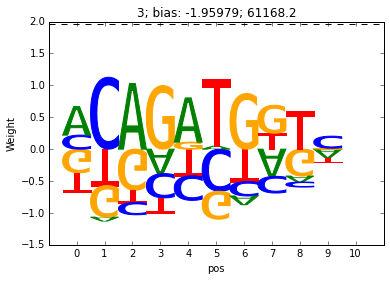

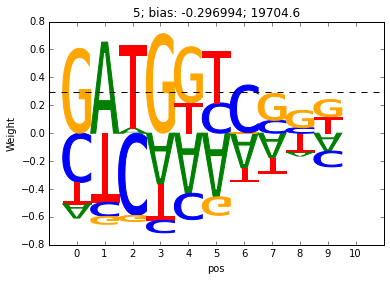

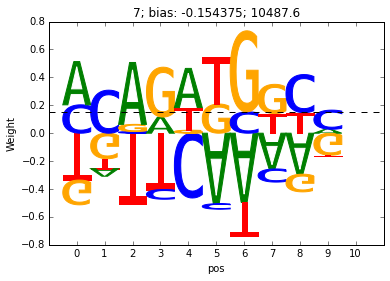

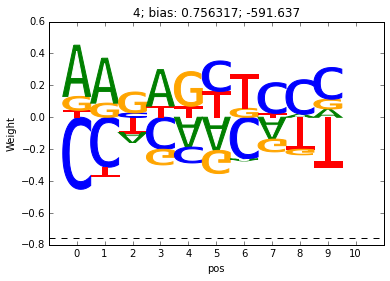

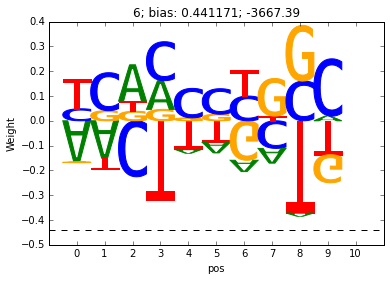

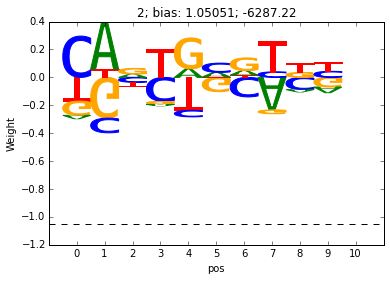

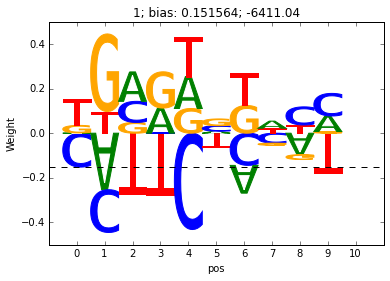

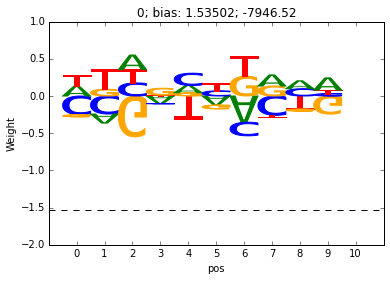

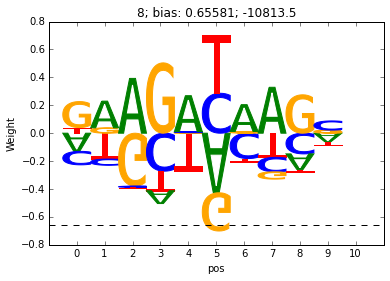

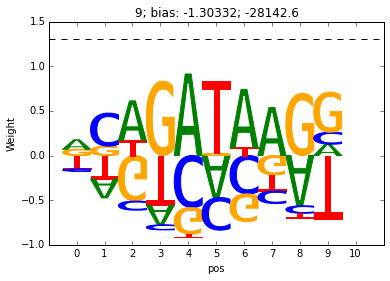

task_idx 2
Done 0
Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500
Done 5000
Done 5500
Done 6000
(6400, 10, 1, 4)


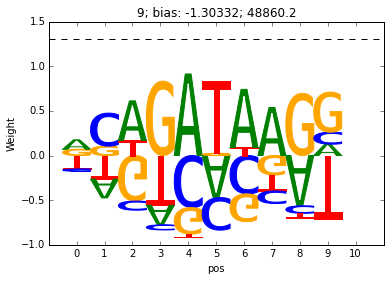

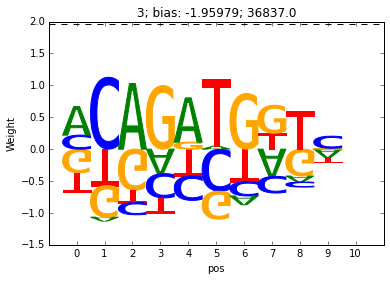

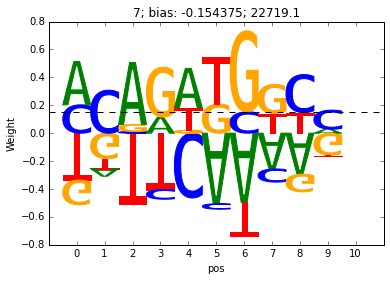

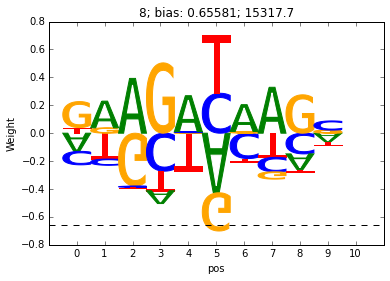

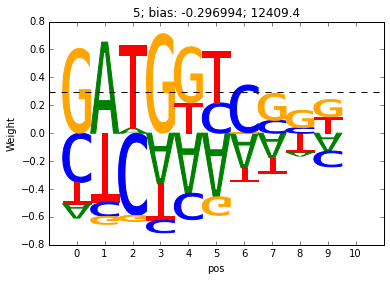

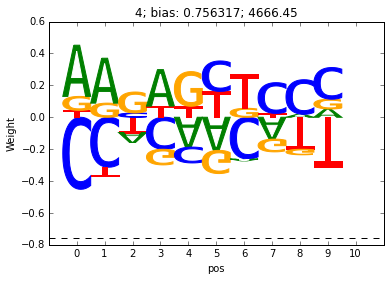

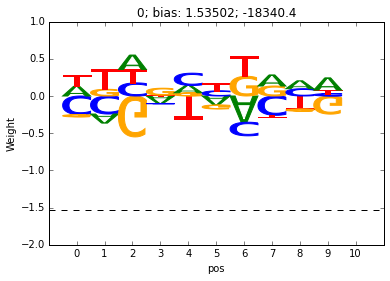

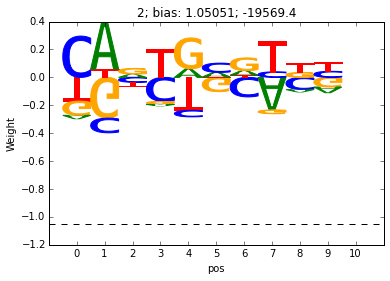

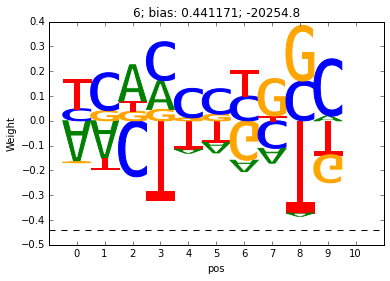

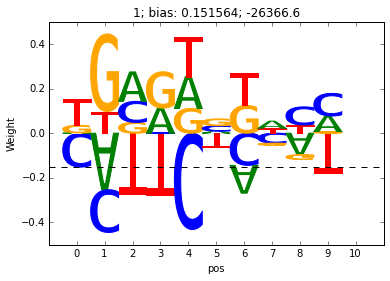

In [15]:
for task_idx in range(3):
    print("task_idx",task_idx)
    filter_scores = np.array(filter_contribs_func(task_idx=task_idx, input_data_list=[data.X], batch_size=500, progress_update=500))
    print(filter_scores.shape)
    filter_scores = np.sum(filter_scores, axis=(0,2,3))
    indices = [x[0] for x in sorted(enumerate(filter_scores), key=lambda x: -x[1])]
    import deepLIFTutils
    [deepLIFTutils.printConvolution(deeplift_model.get_layers()[1].W, deeplift_model.get_layers()[1].b, idx, addToTitle=(str(filter_scores[idx]))) for idx in indices] 

In [16]:
print(sorted(enumerate(zip(deeplift_model.get_layers()[-2].W[:,0], deeplift_model.get_layers()[-4].b)), key=lambda x: -x[1][0]))
print(sorted(enumerate(zip(deeplift_model.get_layers()[-2].W[:,1], deeplift_model.get_layers()[-4].b)), key=lambda x: -x[1][0]))
print(sorted(enumerate(zip(deeplift_model.get_layers()[-2].W[:,2], deeplift_model.get_layers()[-4].b)), key=lambda x: -x[1][0]))

[(1, (1.2932851, 0.56242609)), (0, (-2.3820698, 0.41255963))]
[(0, (0.59103531, 0.41255963)), (1, (-1.7191675, 0.56242609))]
[(1, (-1.3745836, 0.56242609)), (0, (-1.8983537, 0.41255963))]


In [17]:
for i in range(2):
    print("node:",i)
    print(sorted(enumerate(np.sum(np.reshape(deeplift_model.get_layers()[5].W[:,i],(10,4)),axis=1)), key=lambda x: -x[1]))

node: 0
[(1, 2.4704156), (6, 2.2338836), (2, 1.6680019), (0, 1.088532), (3, 0.40937835), (5, 0.15470964), (4, -0.45530823), (7, -0.73536265), (8, -1.473861), (9, -3.1388953)]
node: 1
[(1, 1.9734381), (2, 1.6533993), (6, 1.4992044), (0, 1.4426129), (9, 0.60506827), (8, 0.41254416), (4, -0.090467051), (7, -1.1209884), (5, -1.3335388), (3, -3.2510211)]


In [18]:
deeplift_model.get_layers()[1].W.shape

(10, 1, 4, 10)

Compute the contributions for all 3 tasks and the multipliers for the third task

In [19]:
deeplift_contribs,\
deeplift_expo_upweight_contribs,\
deeplift_multipliers,\
grad_times_inp,\
guided_backprop,\
guided_backprop_deeplift1,\
guided_backprop_deeplift4,\
deconv = [[np.array(contribs_func(task_idx=i, input_data_list=[[data.X[idx]]], batch_size=10, progress_update=None))
                  for i in [0,1,2]]
                  for contribs_func in [deeplift_contribs_func,
                                        deeplift_expo_upweight_contribs_func,
                                        deeplift_multipliers_func,
                                        grad_times_inp_func,
                                        guided_backprop_func,
                                        guided_backprop_deeplift1_func,
                                        guided_backprop_deeplift4_func,
                                        deconv_func]]

Plot away! This relies on importing some plotting functions from the old DeepLIFT code base

424
[ 0.862876    0.86944228  0.76041508]
[ 0.862876    0.86944228  0.76041508]
grad_times_inp
task0_sequence_grad_times_inp_424


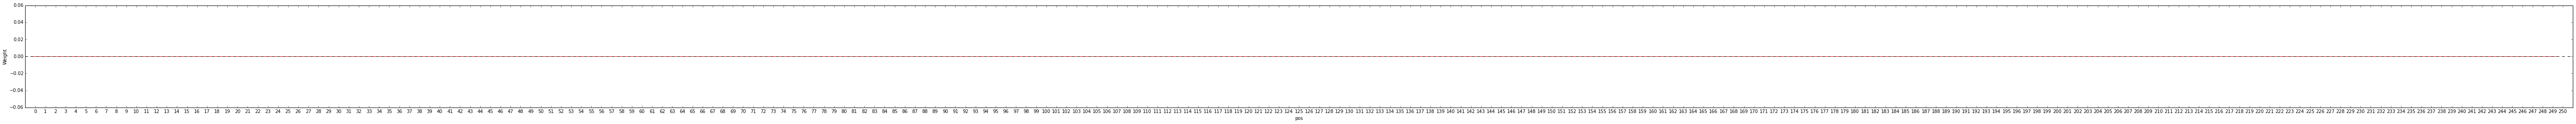

guided_backprop
task0_sequence_guided_backprop_424


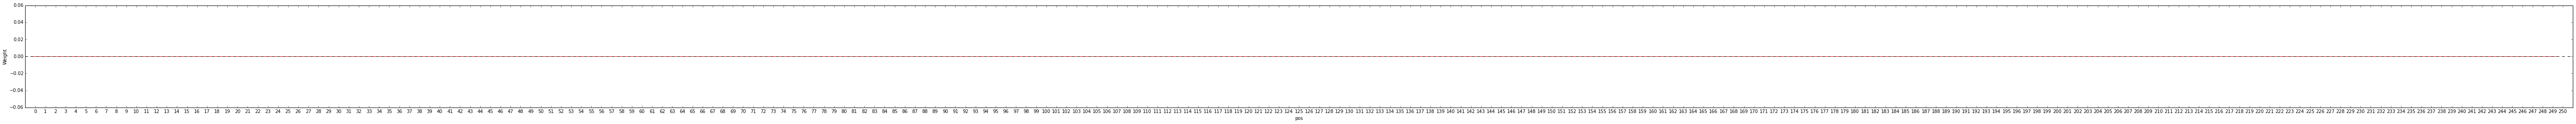

deeplift_contribs
task0_sequence_deeplift_contribs_424


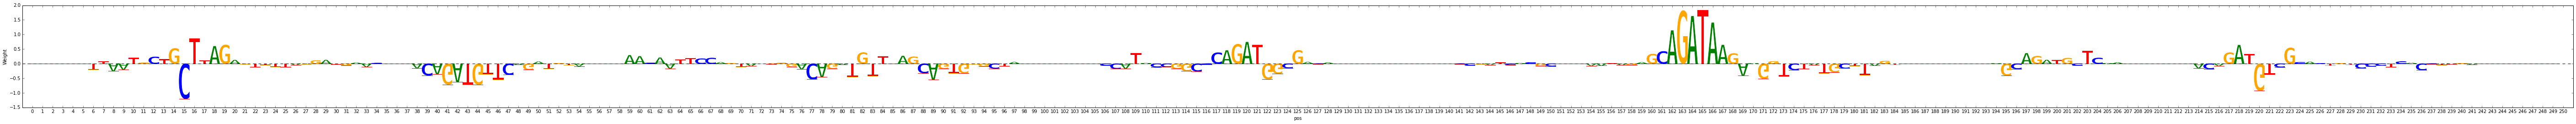

grad_times_inp
task1_sequence_grad_times_inp_424


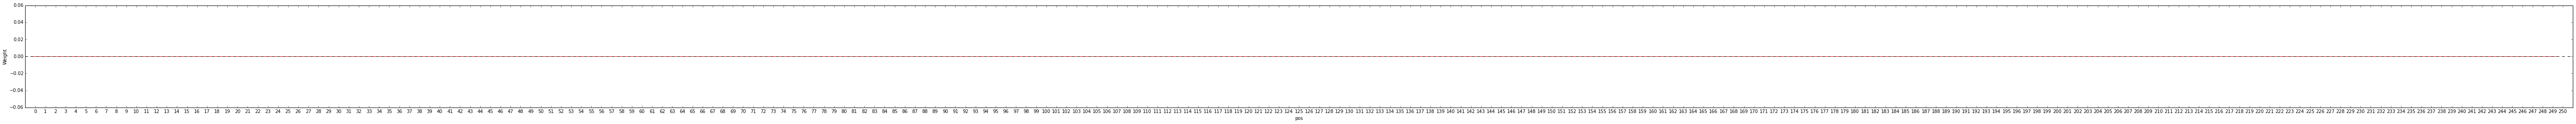

guided_backprop
task1_sequence_guided_backprop_424


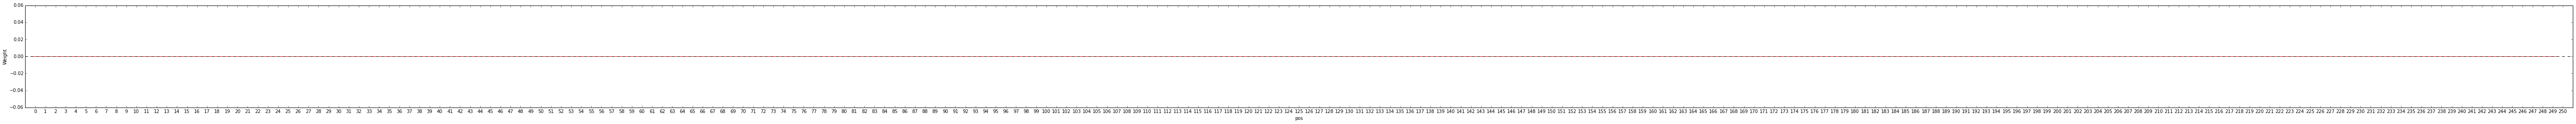

deeplift_contribs
task1_sequence_deeplift_contribs_424


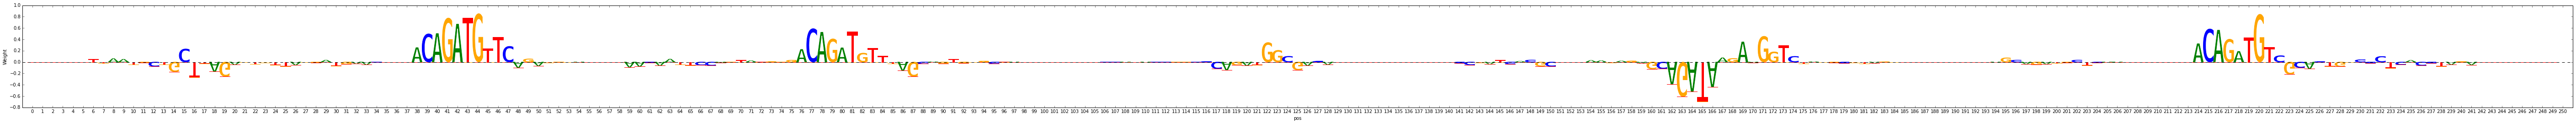

grad_times_inp
task2_sequence_grad_times_inp_424


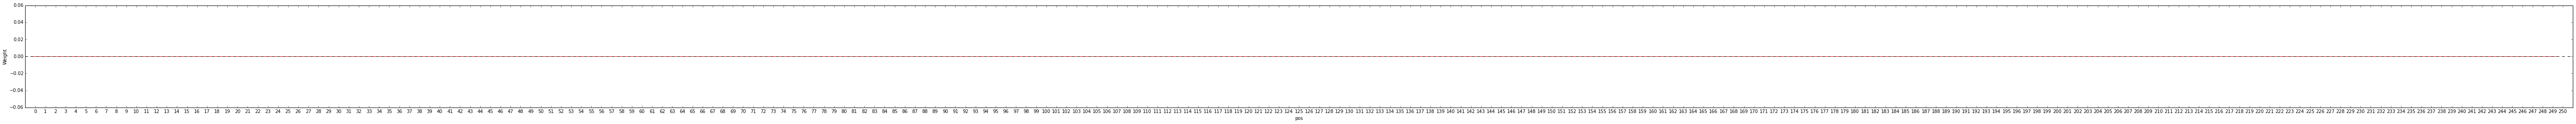

guided_backprop
task2_sequence_guided_backprop_424


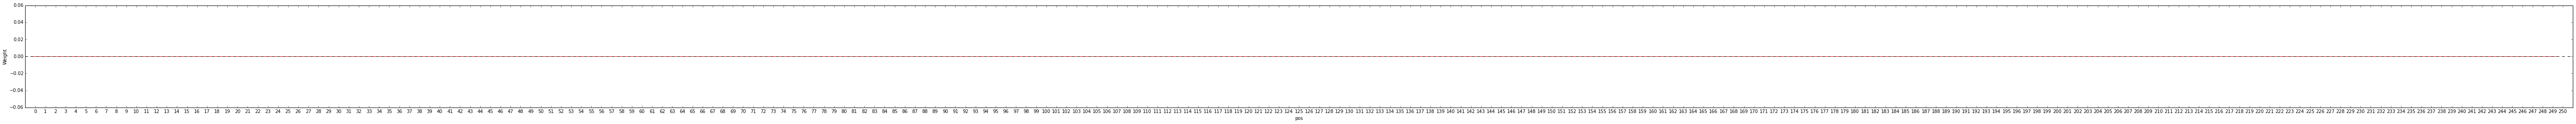

deeplift_contribs
task2_sequence_deeplift_contribs_424


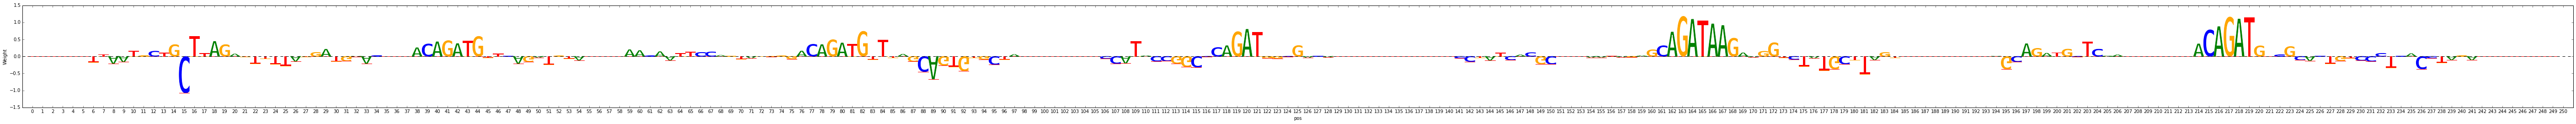

In [21]:
idx = data.ids.index('gataAndTal-synth532')
print(idx)
print(predictions[idx])
#sorted_predictions = sorted(enumerate(np.minimum(predictions[:,0],predictions[:,1])), key=lambda x: -x[1])
#idx = sorted_predictions[0][0]
print(predictions[idx])
for task in [0,1,2]:
    for (scores, scores_name) in [
                #(deconv, 'deconv'),
                (grad_times_inp, 'grad_times_inp'),
                (guided_backprop, 'guided_backprop'),
                (deeplift_contribs, 'deeplift_contribs')]:
                #(deeplift_expo_upweight_contribs, 'deeplift_expo_upweight_contribs'),
                #(deeplift_multipliers, 'deeplift_multipliers'),                                  
                #(guided_backprop_deeplift1, 'guided_backprop_deeplift1'),
                #(guided_backprop_deeplift4, 'guided_backprop_deeplift4')]:
        print(scores_name)
        print("task"+str(task)+"_sequence_"+scores_name+"_"+str(idx))
        makePngOfSequenceDeepLIFTScores(scores[task][0]
                                    , pngName=None)

Plot the multipliers for the third task

In [ ]:
makePngOfSequenceDeepLIFTScores(deeplift_multipliers[2][0]
                                    , pngName="task"+str(2)+"_sequence_multipliers_"+str(idx)+".png")